In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 2s 0us/step


In [4]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


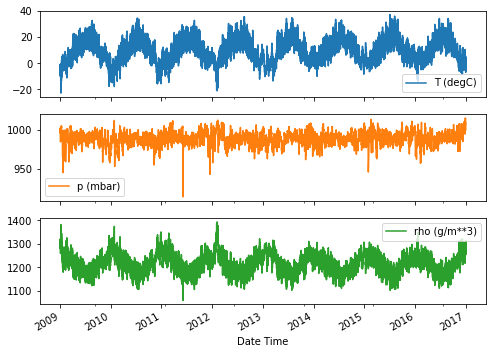

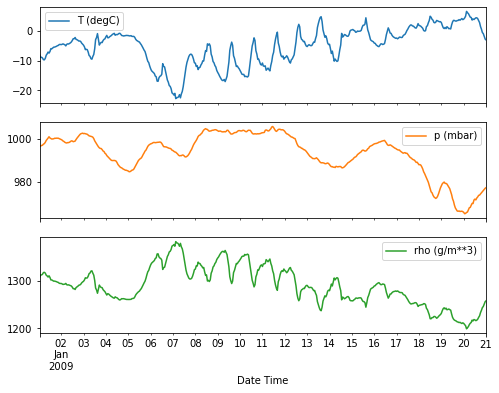

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [8]:
## Replaced abnormal outliers of WV(Wind Velocity)

wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

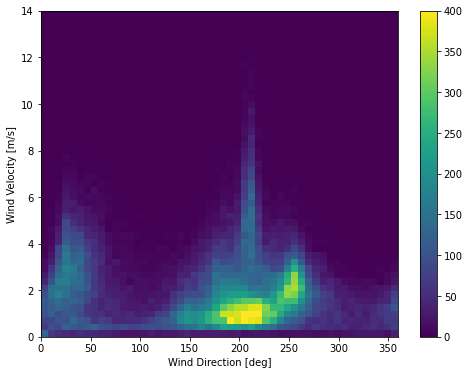

In [9]:


plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [10]:
## 모델은 사람처럼 연관성을 모른다
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

## Convert to radians.  ----- X Y 방향으로 조정 해줌
## 앞의 히스토그램 대신 correlation 이 더 잘 보이게 display 해 줌
## 모델 학습에도 도움이 된다
## DNN 은 column 들 간의 corr 을 상대적으로 잘 못 잡는 경향이 있다.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

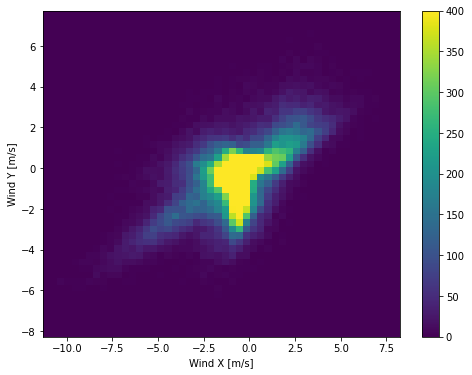

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [13]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

## Timestamp 를 주기 함수 형태로 바꾸어 줌
## Day2Day, Year2Year 변화를 확인할 수 있도록.
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

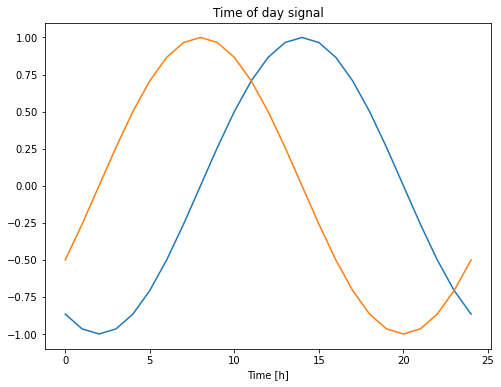

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

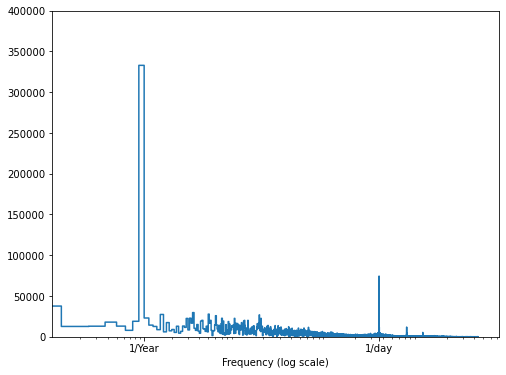

In [15]:
## Fourier Transfor  적용

fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [16]:
## Wx, Wy, Day, Year 의 데이터가 변한 것 확인 

print(len(df.columns))
df.describe()

19


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,7.009100e+04,7.009100e+04,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,-0.627813,-0.407068,-1.018681,-0.733589,1.440353e-04,5.800652e-05,0.001619,-0.000662
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,1.987440,1.552621,3.095279,2.611890,7.071374e-01,7.070862e-01,0.706809,0.707413
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-11.305514,-8.274385,-19.641473,-14.883367,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,-1.470727,-1.364699,-2.469210,-2.322709,-7.071068e-01,-7.071068e-01,-0.704504,-0.708115
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,-0.633142,-0.293467,-1.117029,-0.527021,6.617561e-14,4.141627e-14,0.003316,-0.001122
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,0.299975,0.450077,0.627619,0.822895,7.071068e-01,7.071068e-01,0.708301,0.707423
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,8.244699,7.733831,11.913133,14.302308,1.000000e+00,1.000000e+00,1.000000,1.000000


In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


## Input dimension 의 크기
num_features = df.shape[1]

In [18]:
## Standard Normalization 
## Train mean 과 Train std 를 이용해서 normalization 을 수행

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


## 위 내용을 다른 방법으로 구현
# import sklearn.preprocessing.StandardScaler

# scaler = StandardScaler()
# scaler.fit(x_train, y_train)

# x_train = scaler.transform(x_train) # -> model(x_train)

# import joblib
# joblib.dump(scaler, 'standardscaler.pkl') # train_mean, train_std

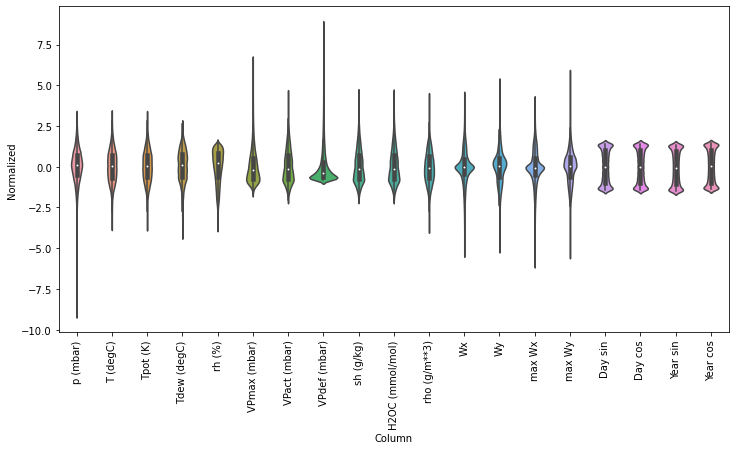

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [32]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [33]:
a = ("a", "b", "c", "d", "e", "f", "g", "h")
x = slice(8)
print(x)
print(type(x))
print(a[x])

slice(None, 8, None)
<class 'slice'>
('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h')


In [34]:
print(np.arange(10))
input_indices = np.arange(10)[x]
print(input_indices)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7]


In [35]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [36]:
!pwd

/c/Users/SNUAI/Excercise/ML_Excercise
